Problem statement: Train a model on CalIt2 Building People Counts dataset to predict people count given any time interval.

Time-series forecasting is an interesting field and getting good accuracy on time-series datasets is
difficult. Training a model on multivariate time-series dataset is difficult as compared to univariate
time-series dataset. Selecting the best algorithm and the best hyperparameters for that algorithm
should be your goal while training the model.

Implemetation overview: I've separated the inflow and outflow data and applied ARIMA individually on both of them. Then to calculate the people count, I subtract the outflow count prediction from inflow count prediction at a given time interval.

## Read and Parse Data
*All the inflow visualization use green colored graphs while the outflow visualizations use blue colored graphs. Predictions are in red.*

C:\Users\Simmi Mourya\AppData\Local\conda\conda\envs\aind-dog-updated\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Simmi Mourya\AppData\Local\conda\conda\envs\aind-dog-updated\lib\site-packages\ipykernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                     count
datetime                  
2005-07-24 00:00:00      0
2005-07-24 00:30:00      0
2005-07-24 01:00:00      0
2005-07-24 01:30:00      0
2005-07-24 02:00:00      0


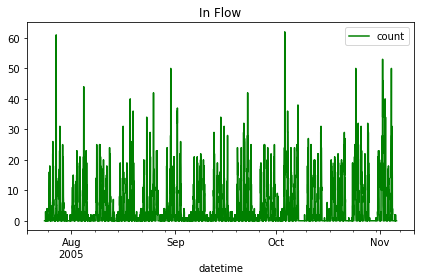

                     count
datetime                  
2005-07-24 00:00:00      0
2005-07-24 00:30:00      1
2005-07-24 01:00:00      0
2005-07-24 01:30:00      0
2005-07-24 02:00:00      0


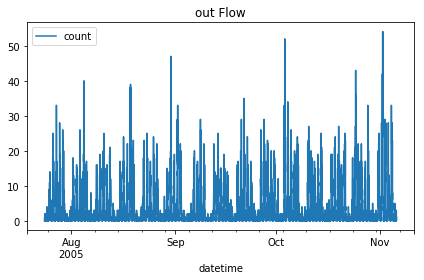

In [22]:
import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
 
# read and parse data 
df = read_csv('Calit2.csv', header=0, squeeze=True)

# merge date time and join with main df
date_time = pd.to_datetime(df['date'] + ' ' + df['time'])

df.drop('date', axis=1, inplace=True)
df.drop('time', axis=1, inplace=True)

cali_df = pd.concat([df, date_time], axis=1)
cali_df.columns = ['flowid', 'count', 'datetime']

# separate inflow and outflow df
out_df = cali_df.loc[cali_df['flowid'] == 7]

in_df = cali_df.loc[cali_df['flowid'] == 9]

out_df.drop('flowid', axis=1, inplace=True)
in_df.drop('flowid', axis=1, inplace=True)

# # set index as datetime to support plotting and Arima Model
out_df.set_index('datetime', inplace=True)
in_df.set_index('datetime', inplace=True)

# Let's predict for in flow first

print(in_df.head())

in_df.plot(title='In Flow', color = 'green')
pyplot.tight_layout()
pyplot.show()

print(out_df.head())

out_df.plot(title='out Flow')
pyplot.tight_layout()
pyplot.show()


In [9]:
in_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5040 entries, 2005-07-24 00:00:00 to 2005-11-05 23:30:00
Data columns (total 1 columns):
count    5040 non-null int64
dtypes: int64(1)
memory usage: 78.8 KB


## Let's predict for in flow first


                             ARIMA Model Results                              
Dep. Variable:                D.count   No. Observations:                 5039
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -14398.417
Method:                       css-mle   S.D. of innovations              4.214
Date:                Tue, 06 Feb 2018   AIC                          28810.835
Time:                        20:32:22   BIC                          28856.510
Sample:                    07-24-2005   HQIC                         28826.837
                         - 11-05-2005                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.776e-17      0.035  -7.94e-16      1.000      -0.069       0.069
ar.L1.D.count    -0.4004      0.014    -28.424      0.000      -0.428      -0.373
ar.L2.D.count    -0.2040      0.015    -

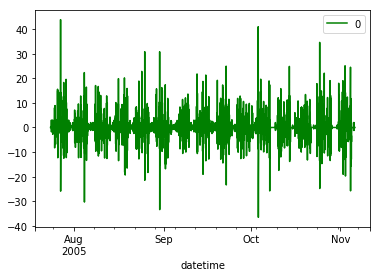

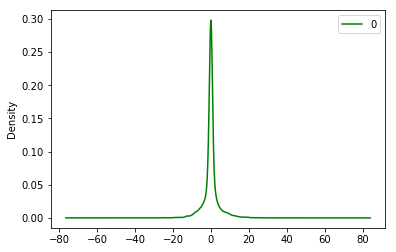

                  0
count  5.039000e+03
mean   1.339582e-17
std    4.214528e+00
min   -3.649434e+01
25%   -6.505716e-01
50%    4.712930e-17
75%    2.155246e-01
max    4.380504e+01


In [33]:
from statsmodels.tsa.arima_model import ARIMA 

model = ARIMA(in_df.astype('float64'), order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(color= 'green')
pyplot.show()
residuals.plot(kind='kde', color= 'green')
pyplot.show()
print(residuals.describe())

## Autocorrelation - Inflow

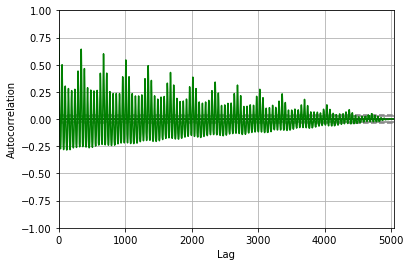

In [32]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(in_df.astype('float64'), color= 'green' )
pyplot.show()

## Fit - Inflow

In [35]:
from tqdm import tqdm

X = in_df.astype('float64').values
size = int(len(X) * 0.66)
train_in, test_in = X[0:size], X[size:len(X)]
history = [x for x in train_in]
predictions_in = list()
print('Total Test cases: {}'.format(len(test_in)))
for t in tqdm(range(len(test_in))):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions_in.append(yhat)
    obs = test_in[t]
    history.append(obs)

Total Test cases: 1714


100%|█████████████████████████████████████████████████████████████████████████████▋| 1708/1714 [03:19<00:00,  7.60it/s]C:\Users\Simmi Mourya\AppData\Local\conda\conda\envs\aind-dog-updated\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
100%|██████████████████████████████████████████████████████████████████████████████| 1714/1714 [03:20<00:00,  7.07it/s]


## Prediction and error calculation - Inflow

Test MSE: 21.312


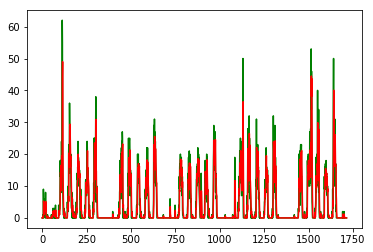

In [38]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test_in, predictions_in)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test_in, color='green')
pyplot.plot(predictions_in, color='red')
pyplot.show()


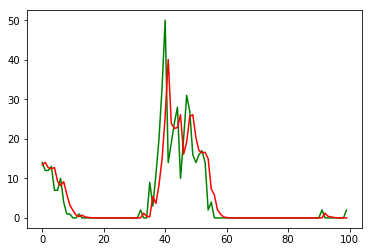

In [56]:
# Let's zoom in

pyplot.plot(test_in[1600: 1700], color='green')
pyplot.plot(predictions_in[1600: 1700], color='red')
pyplot.show()


## Let's predict for outflow

                             ARIMA Model Results                              
Dep. Variable:                D.count   No. Observations:                 5039
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -13999.528
Method:                       css-mle   S.D. of innovations              3.893
Date:                Tue, 06 Feb 2018   AIC                          28013.055
Time:                        20:22:45   BIC                          28058.730
Sample:                    07-24-2005   HQIC                         28029.057
                         - 11-05-2005                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          8.733e-05      0.030      0.003      0.998      -0.058       0.058
ar.L1.D.count    -0.4649      0.014    -33.005      0.000      -0.493      -0.437
ar.L2.D.count    -0.2611      0.016    -

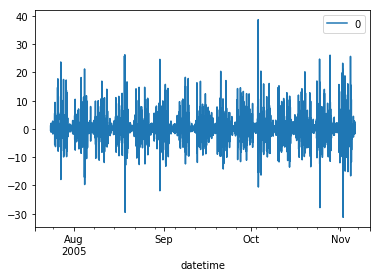

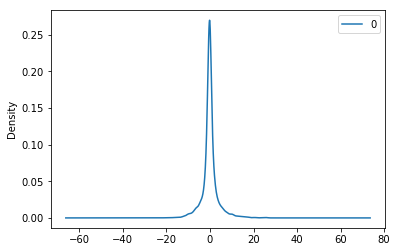

                 0
count  5039.000000
mean      0.000068
std       3.893744
min     -31.246140
25%      -1.035249
50%      -0.071413
75%       0.837109
max      38.624522


In [23]:
from statsmodels.tsa.arima_model import ARIMA 

model = ARIMA(out_df.astype('float64'), order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

## Autocorrelation - Outflow

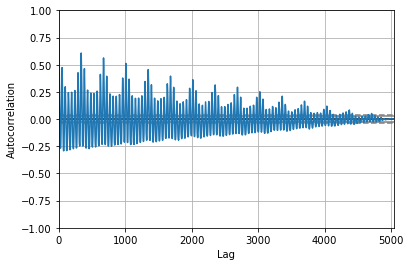

In [25]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(out_df.astype('float64'))
pyplot.show()

## Fit - Outflow

In [57]:
from tqdm import tqdm

X = out_df.astype('float64').values
size = int(len(X) * 0.66)
train_out, test_out = X[0:size], X[size:len(X)]
history = [x for x in train_out]
predictions_out = list()
print('Total Test cases: {}'.format(len(test_out)))
for t in tqdm(range(len(test_out))):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions_out.append(yhat)
    obs = test_out[t]
    history.append(obs)

Total Test cases: 1714


 29%|██████████████████████▌                                                        | 490/1714 [01:02<02:34,  7.94it/s]C:\Users\Simmi Mourya\AppData\Local\conda\conda\envs\aind-dog-updated\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
100%|██████████████████████████████████████████████████████████████████████████████| 1714/1714 [04:04<00:00,  8.14it/s]


## Prediction and error calculation - Outflow

Test MSE: 20.029


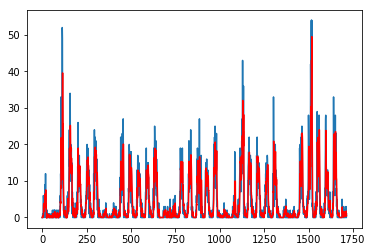

In [58]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test_out, predictions_out)
print('Test MSE: %.3f' % error)

# plot
pyplot.plot(test_out)
pyplot.plot(predictions_out, color='red')
pyplot.show()


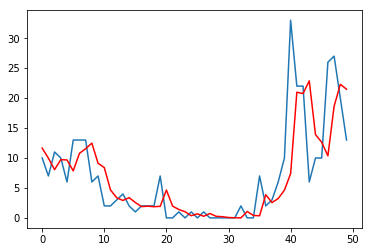

In [61]:
# Let's zoom in

pyplot.plot(test_out[1600: 1650])
pyplot.plot(predictions_out[1600: 1650], color='red')
pyplot.show()


### Let's caluclate people count inside the building for a given time interval

### Plot of people count present in the building at different time intervals - Actual vs prediction

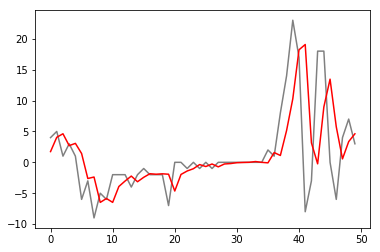

In [94]:
import numpy as np

# since it's a list of arrays
predictions_in_arr = np.vstack(predictions_in)
predictions_out_arr = np.vstack(predictions_out)

test_count = test_in[1600: 1650] - test_out[1600: 1650]
prediction_count = predictions_in_arr[1600: 1650] - predictions_out_arr[1600: 1650]

pyplot.plot(test_count, color='gray')
pyplot.plot(prediction_count, color='red')

pyplot.show()

